In this notebook, I took out the feature extractor (a pre-trained model) from the Data Loader and added it into the Encoder. The name of the notebook also holds this: *_TRansferLEarningInENCoder

In [58]:
import os
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import (CosineAnnealingLR,
                                      CosineAnnealingWarmRestarts,
                                      StepLR,
                                      ExponentialLR)
import sklearn.utils
from sklearn.model_selection import train_test_split

In CeDAR (Center for Data Analytics Research, ADA University) option, the notebook shall connevt to the local machine (where the whole dataset is supposed to be). To connect to the CeDAR's environment run the following to start Jupyter with access:


```
jupyter notebook \
>   --NotebookApp.allow_origin='https://colab.research.google.com' \
>   --port=8888 \
>   --NotebookApp.port_retries=0
```
Then select "Connect to a local runtime" and put the link of notebook environment (from the console)



In [59]:
class Config:
    debug = False
    env = 'Prod' # Dev (Jamal's GoogleDrive), Prod (SLR GDrive) or CeDAR (local)
    csv_path = ''
    seed = 44
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    video_processing_tool = 'TorchVision' # OpenCV, VidGear or TorchVision
    max_frames = 64
    max_words_in_sentence = 10


    drive_folder = '/home/sign-lang/jamal/Dataset' # path for the local (CeDAR)
    if (env == 'Dev'):
      drive_folder = 'drive/MyDrive/SLR_test'
    elif (env == 'Prod'):
      drive_folder = 'drive/MyDrive/SLR/Data'
    
    video_folder = drive_folder+'/Video'

    train_csv_path = drive_folder+'/sentences_all.csv'
    camera_source = 'Cam2' # Cam1 - side-top, Cam2 - front
    BATCH_SIZE = 1 #updated before the training

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
#    torch.manual_seed(seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed(seed)

config = Config()
seed_everything(config.seed)
print('Running on',config.device)
if torch.cuda.is_available():
    print('GPU number:',torch.cuda.device_count())

Running on cuda:0
GPU number: 1


In [60]:
if (config.env != 'CeDAR'):
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import sys
import subprocess

def pip_install(package):
  subprocess.check_call([sys.executable, '-m', 'pip', 'install',package])

In [62]:
pip_install('mediapipe')

# https://github.com/jbohnslav/opencv_transforms
pip_install('opencv_transforms')

if config.video_processing_tool == 'VidGear':
  pip_install('vidgear[core]')

In [63]:
train_set_size = 50

# read cvs file
sentences = pd.read_csv(config.train_csv_path)
sentences = sentences.iloc[:,:train_set_size]

# unique words
word_set = set(['SOS','EOS'])
sentences.iloc[:,2].str.lower().str.split().apply(word_set.update)
sorted_word_set = sorted(word_set)
print('Unique words',sorted_word_set)

# create word encoding
encodings = { k:v for v,k in enumerate(sorted_word_set)}
word_idx  = { v:k for k,v in encodings.items()}
print('Word encodings',encodings)
print('Words by index',word_idx)
torch.save(encodings,config.drive_folder+'/jamal/encodings.dict')
torch.save(word_idx,config.drive_folder+'/jamal/word_idx.dict')

# converts a sentence with zero padded encoding list
def get_sentence_encoded(sentence):
    encoded = [encodings[key] for key in ('SOS '+sentence+' EOS').split()]
    return  encoded + list([0]) * (config.max_words_in_sentence - len(encoded))

if config.debug:  
  print(get_sentence_encoded('mən hansı sənəd vermək'))
  print(get_sentence_encoded('mən bakı yaşamaq'))

# generate (video file name, encoding list)
# Good recommendation on not to iterate over DFs like this:
# https://stackoverflow.com/questions/16476924/how-to-iterate-over-rows-in-a-dataframe-in-pandas
# but it's not my case - I have fewer rows and one to many with videos.
df = pd.DataFrame(columns=["id", "video_file","encoding"])

for index, row in sentences.iterrows():
    id = int(row[0])
    phrase = row[2].lower()
    encoded = get_sentence_encoded(phrase)

    # there is a grouping of videos in production.
    pre_folder = '/1-250/' if (config.env == 'Prod' and id < 251) else '/'
    
    dir = config.video_folder+'/'+config.camera_source +pre_folder+str(id)
    # iterate over video folders
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            entry = pd.DataFrame.from_dict({"id": id, "video_file": f, "encoding": [encoded]})
            df = pd.concat([df, entry], ignore_index = True)

if config.debug:
    print(df)

Unique words ['"dolu"', '%', ',', '1', '1-2', '10', '100', '103', '11:15', '12', '12:30', '14', '15', '1979', '2', '2015', '2018', '2019', '2022', '23', '24', '28', '29', '3', '4', '40', '43', '5', '6', '65', '67', '7', '8', '?', 'EOS', 'SOS', 'abşeron', 'ac', 'acı', 'acılıq', 'acımaq', 'ad', 'ada', 'adam', 'adamlar', 'adası', 'administrator', 'ailə', 'alaq', 'aldatmamaq', 'aldatmaq', 'aldığın', 'alergiya', 'alma', 'almaniya', 'almaq', 'altında', 'alıb', 'alınacaq', 'aləm', 'amerika', 'amma', 'ana', 'anam', 'ani', 'anlamamaq,', 'anlamaq', 'aparat', 'aparmaq', 'aprel', 'arayış', 'araşdırılır', 'artist', 'artmaq', 'artıq', 'artırmaq', 'arxanca', 'asan', 'asif', 'asma', 'asmaq', 'asvalt', 'ata', 'atam', 'atmaq', 'avtobus', 'avtomobil', 'avtomobiı', 'axsamaq', 'axtarmaq', 'axşam', 'ay', 'ayaq', 'ayaqqabı', 'ayaqyolu', 'aygül', 'ayı', 'ayın', 'az', 'azərbaycan', 'açmaq', 'açmaq,', 'açılmaq', 'açıq', 'ağlamaq', 'ağlım', 'ağlında', 'ağrı', 'ağrımaq', 'ağrıyır', 'ağıllı', 'ağır', 'aşağı', 'bab

This small piece of code is to test the outputs of the pre-trained model.

In [64]:
# from torchvision.models.feature_extraction import create_feature_extractor

# x = torch.rand(1, 3, 224, 224).to(config.device)

# return_nodes = {
#     'features.12.cat': 'layer12'
# }
# model_new = create_feature_extractor(model, return_nodes=return_nodes).to(config.device)

# result = model_new(x)
# n,out_filters,out_width,out_height = result['layer12'].shape
# print(n,out_filters,out_width,out_height)

In [65]:
import math

rows = int(math.sqrt(config.max_frames))
cols = config.max_frames//rows

def visualize_frames(frames):
  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
  
  idx = 0
  for i in range(rows):
      for j in range(cols):
        axes[i, j].imshow(frames[0,idx,:,:,:].permute(1,2,0).cpu())
        idx += 1

TODO: Implement augmentation to the data

In [66]:
pip_install('pytorchvideo')

In [67]:
from torchvision import transforms

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    UniformTemporalSubsample,
    Permute,   
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    CenterCrop,
    RandomAdjustSharpness,
    Resize,
    ColorJitter,
    RandomHorizontalFlip
)

from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo
)

In [68]:
import cv2
import mediapipe as mp

# New mediapipe modules
# from mediapipe.tasks import python
# from mediapipe.tasks.python import vision

# Old Mediapipe code

# New Mediapipe code
# base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
# options = vision.HandLandmarkerOptions(base_options = base_options,num_hands=2)
# detector = vision.HandLandmarker.create_from_options(options)

# keeps only informative frames

def keep_frames_with_hands(video_data, crop_size: int = None,
                           mp_min_detection_confidence: float = 0.8, mp_min_tracking_confidence: float = 0.9): # initially 0.5, 0.2 / 0.5 0.7
  """

  Args:
      video_data (_type_): _description_
      crop_size (int, optional): crop_size for imag
      e transform. Defaults to 224.
      video_transfrom (torchvision.transforms.Compose, optional): transformations to be applied to the video. Defaults to None.

  Returns:
      torch.Tensor(): processed video tensor
  """
    
  mpHands = mp.solutions.hands
  hands = mpHands.Hands(static_image_mode=True, max_num_hands=2,
                        min_detection_confidence=mp_min_detection_confidence, min_tracking_confidence=mp_min_tracking_confidence)
  
  if crop_size:
    video_arr = torch.zeros((0, 3, crop_size, crop_size)).to(config.device)
    transform = Compose([
      CenterCrop(crop_size),
      ])
  else:
    video_arr = torch.zeros((0, 3, 960, 1280)).to(config.device)

    # Note: keeping this old code to know how to get frame count from different libs
    #  
    # frame_count = 0
    # if config.video_processing_tool == 'OpenCV':
    #   frame_count = int(video_data.get(cv2.CAP_PROP_FRAME_COUNT))
    # elif config.video_processing_tool == 'VidGear':
    #   frame_count = int(video_data.stream.get(cv2.CAP_PROP_FRAME_COUNT))
    # elif config.video_processing_tool == 'TorchVision':
    #   metadata = video_data.get_metadata()
    #   frame_count = metadata['video']['duration'][0] * metadata['video']['fps'][0]
    #   video_data.set_current_stream("video")


  
  ret = True
  frame = None

  for frame in video_data:
    hand_results = hands.process(frame.numpy())

  #   # New Mediapipe code
      # hand_results = detector.detect(frame)

    if hand_results.multi_hand_landmarks != None:
      if crop_size:
        frame_ext = torch.unsqueeze(transform(frame.permute(2, 0, 1)), dim=0).to(config.device)
      else:
        frame_ext = torch.unsqueeze(frame.permute(2, 0, 1), dim=0).to(config.device)

      video_arr = torch.cat((video_arr, frame_ext/255.0),0)
      
    
  return video_arr

TODO: It seems the data is not read randomly. It's read sequentially.

In [69]:
def get_video_transforms(resize_size: int = 224):
    video_transform=Compose([
        Resize(size=(resize_size, resize_size)),
        # UniformTemporalSubsample(25),
        ColorJitter(brightness=0.5, contrast=0.5),
        # RandomShortSideScale(min_size=256, max_size=512),
        RandomHorizontalFlip(p=0.5),
    ])
    
    return video_transform

In [70]:
if config.video_processing_tool == 'VidGear':
  from vidgear.gears import CamGear
import torchvision
from torchvision.models.feature_extraction import create_feature_extractor

class SLDataset(Dataset):

    def __init__(self, df, video_transform: bool = True):
        # shuffle and save
        self.df = sklearn.utils.shuffle(df)
        self.video_transform = video_transform

    def __getitem__(self, idx):
        if config.debug:
          print(f"Got item at index: {idx}")
        video_path = df.iloc[idx,1]

        encoding = torch.tensor(df.iloc[idx,2]).to(config.device)
        enc_shape = encoding.shape[0]

        reader = None
        #--- keep frames with hands
        if config.video_processing_tool == 'OpenCV':
          reader = cv2.VideoCapture(video_path)
        elif config.video_processing_tool == 'VidGear':
          reader = CamGear(video_path).start()
        elif config.video_processing_tool == 'TorchVision':
          reader, _, _ = torchvision.io.read_video(video_path, output_format="THWC")
        


        hands_only = keep_frames_with_hands(reader, crop_size=600).to(config.device) # initially: 960
        video_transforms = get_video_transforms()

        if self.video_transform:
          video_transform = get_video_transforms()
          hands_only = video_transforms(hands_only) # applies video transformations
                
        if config.debug:
          print(f"Hands only shape: {hands_only.shape}")
        if config.video_processing_tool == 'OpenCV':
          reader.release()
        elif config.video_processing_tool == 'VidGear':
          reader.stop()
        elif config.video_processing_tool == 'TorchVision':
          pass


        n,l,w,h = hands_only.shape
        
        if config.debug:
          print(idx,video_path,encoding,'Frames:',n)

        # When frames are more than we need but not that much (just trim it from the start and end)
        if (n > config.max_frames) and (n < 2*config.max_frames):
          left = (n-config.max_frames)//2
          hands_only_new = hands_only[left:(n-left-1),:,:,:]
        # If we have much more frames than we need
        elif (n > config.max_frames):
          # Cut 5 frames from start/end and then skip every n-th
          slice_step = ((n-10)//config.max_frames+1)
          hands_only_new = hands_only[5:(n-5):slice_step,:,:,:]
        else:
          hands_only_new = hands_only

        n = hands_only_new.shape[0]

        # If we have less frames than we need
        if (n < config.max_frames):
          # Previous approach : fill with the zero matrix
          # compliment_arr = torch.zeros(config.max_frames-n,l,w,h).to(config.device)
          # New approach: fill with the last frames (usually 1)
          compliment_arr = hands_only[-(config.max_frames-n):,:,:,:]
          hands_only_new = torch.cat((hands_only_new,compliment_arr),0)

        return hands_only_new, torch.reshape(encoding,(enc_shape,1)),video_path

    def __len__(self):
        return len(self.df)

def get_dataloader(df, phase: str, batch_size: int = 96) -> DataLoader:
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=config.seed, stratify=df['id'])
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    df = train_df if phase == 'train' else val_df
    dataset = SLDataset(df, video_transform=True)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=0, shuffle=True)
    return dataloader


# dl = get_dataloader(df,'train',1, video_transform=None)
dl = get_dataloader(df,'train',1)


In [71]:
dl_next = next(iter(dl))
a,b,fname = dl_next

if config.debug:
  print(a.shape,b.shape,fname)
  visualize_frames(a)

/usr/local/lib/python3.9/dist-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


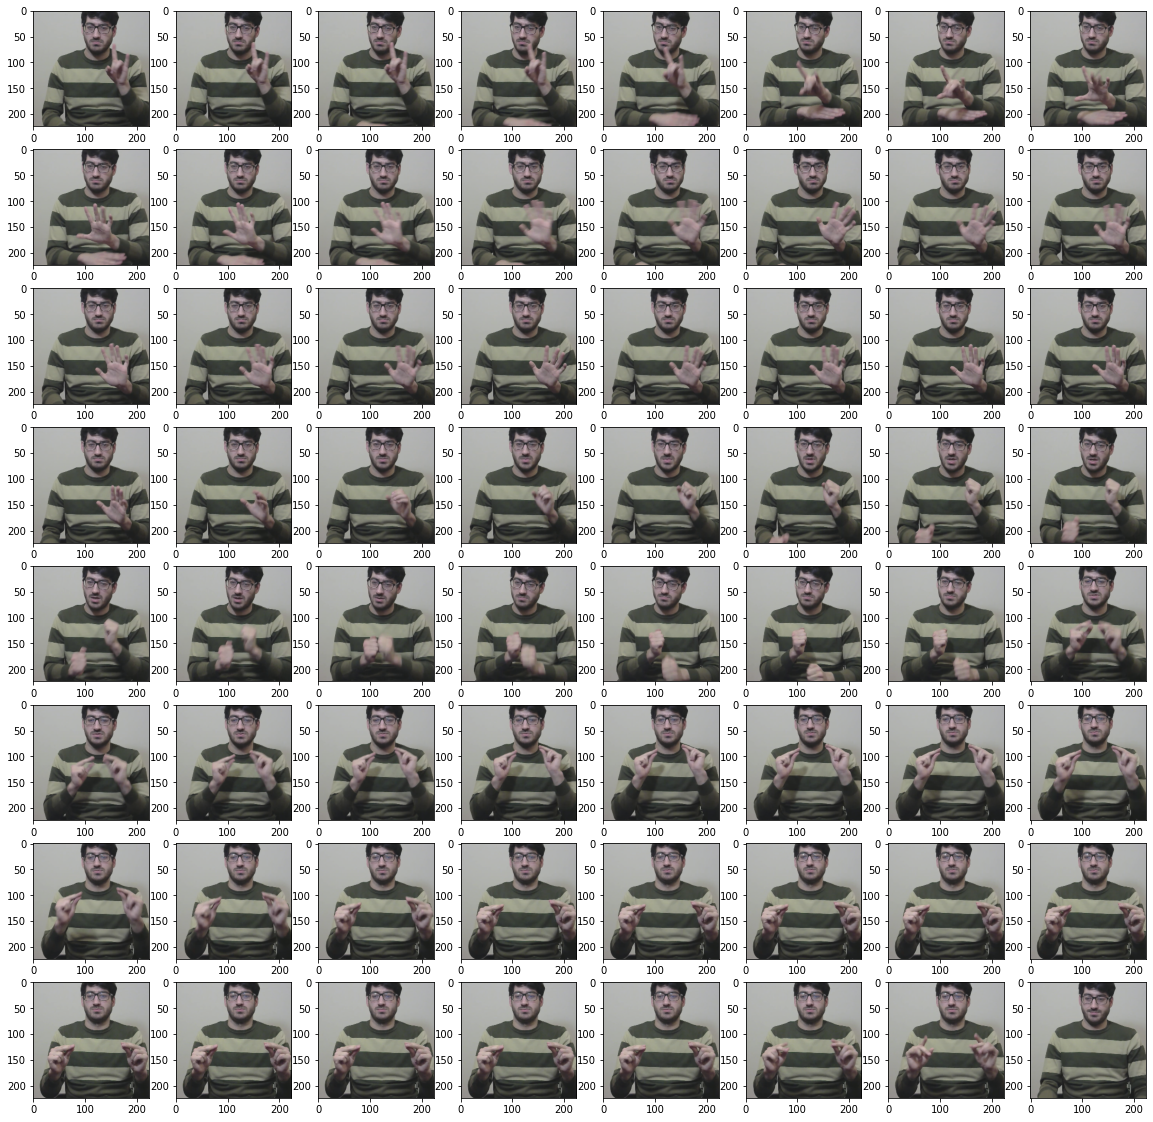

In [72]:
visualize_frames(a)

In [73]:
import torchvision
from torchvision.models import squeezenet1_1
from torchvision.models.feature_extraction import create_feature_extractor

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, device, biDirectional = False):
        super(EncoderRNN, self).__init__()
        
        model = squeezenet1_1(pretrained=True).to(config.device)
        return_nodes = {
            'features.12.cat': 'layer12'
        }
        self.pretrained_model = create_feature_extractor(model, return_nodes=return_nodes).to(config.device)
        self.pretrained_model.eval()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
        self.D = 2 if biDirectional else 1

        self.rnn = nn.LSTM(
                input_size = self.input_size,
                hidden_size = self.hidden_size*self.D,
                num_layers = 1,
                dropout = 0,
                bidirectional = biDirectional,
                batch_first = True).to(config.device)

    def forward(self, input, hidden):
        features = self.pretrained_model(input.squeeze())['layer12'].to(device=self.device)
        feat_shape = features.shape

        feat_flat =  torch.reshape(features,(1,feat_shape[0],feat_shape[1]*feat_shape[2]*feat_shape[3])).to(device=self.device)

        output, hidden = self.rnn(feat_flat, hidden)
        return output, hidden

    def initHidden(self):
        return (torch.zeros(self.D, config.BATCH_SIZE, self.hidden_size*self.D, device=self.device),
                torch.zeros(self.D, config.BATCH_SIZE, self.hidden_size*self.D, device=self.device))

In [74]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, device, dropout_p=0.1, max_length=config.max_frames, biDirectional = False, debug=False): #max_length=config.max_words_in_sentence
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.debug = debug
        self.device = device

        self.D = 2 if biDirectional else 1

        if self.debug:
          print('Attn.init() hidden_size',hidden_size)
          print('Attn.init() output_size',output_size)
          print('Attn.init() max_length',max_length)

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 3, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.rnn = nn.LSTM(
                input_size = self.hidden_size,
                hidden_size = self.hidden_size*self.D,
                num_layers = 1,
                dropout = 0,
                bidirectional = biDirectional,
                batch_first = True)
        self.out = nn.Linear(self.hidden_size*self.D, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(input.shape[0],input.shape[1], self.hidden_size)
        embedded = self.dropout(embedded)
        if self.debug:
          print('Attn.forward() input',input.shape)
          print('Attn.forward() hidden',type(hidden),len(hidden),hidden[0].shape)
          print('Attn.forward() encoder_outputs',encoder_outputs.shape)
          print('embedded: ',embedded.shape)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1).to(device=self.device)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs).to(device=self.device)

        output = torch.cat((embedded[0], attn_applied[0]), 1).to(device=self.device)
        output = self.attn_combine(output).unsqueeze(0).to(device=self.device)

        output = F.relu(output)
        output, hidden = self.rnn(output, (hidden[0].unsqueeze(0),hidden[0].unsqueeze(0)))

        output = F.log_softmax(self.out(output[0]), dim=1).to(device=self.device)
        return output, hidden, attn_weights

    def initHidden(self):
        return (torch.zeros(self.D, 1, self.hidden_size*self.D, device=self.device),
                torch.zeros(self.D, 1, self.hidden_size*self.D, device=self.device))

In [75]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=config.max_words_in_sentence):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    if config.debug:
      print('Input len',input_tensor.shape,'Target len',target_tensor.shape)

    loss = 0

    encoder_hidden = encoder.initHidden()
    encoder_output, encoder_hidden = encoder(input_tensor, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input  = target_tensor[:,:(max_length-2),:]   # words from 1 to n-1
    decoder_target = target_tensor[:,1:(max_length-1),:]  # words from 2 to n (the target to the input word is the next word)
    tar_1hot = torch.nn.functional.one_hot(decoder_target, num_classes = len(encodings))

    if config.debug:
      print('Encoder hidden_0',len(encoder_hidden),'shape',encoder_hidden[0].shape)
      print('enc_out',encoder_output.shape)
      print('dec_in',decoder_input.shape)
      print('dec_target',decoder_target.shape)

    target_length = decoder_target.size(1)

    for di in range(target_length):
        if config.debug:
          print('dec hidden', decoder_hidden[0].shape,decoder_hidden[1].shape)
        
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input[:,di,:], decoder_hidden[0], encoder_output)

        if config.debug:
          print('decoder_output & attn',decoder_output.shape, decoder_attention.shape)

        loss += criterion(decoder_output.squeeze(0), tar_1hot[0,di,:].squeeze(0).double())

        if (decoder_target[:,di,:] == torch.tensor(encodings['EOS'], device=config.device)):
          break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
  
    return loss.item() / (config.BATCH_SIZE*target_length)

In [76]:
import time
from torch import optim
import torch.nn.functional as F
import gc

def trainIters(encoder, decoder, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

    criterion = nn.CrossEntropyLoss()

    trainloader = get_dataloader(df,'train',config.BATCH_SIZE)

    max_epochs = 1

    iter = 1
    start = time.time()
    for epoch in range(max_epochs):
      print('Starting epoch', epoch)
      for inputs, labels,fname in trainloader:
          if (iter%10 == 0):
            print('|', end = '')
          else:
            print('.', end = '')
          input_tensor = inputs.to(config.device)
          target_tensor = labels.to(config.device)

          try:
            loss = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)
          except Exception as exp:
            print('There was an error: ',fname,exp)
            continue

          print_loss_total += loss
          plot_loss_total += loss

          if iter % print_every == 0:
              print_loss_avg = print_loss_total / print_every
              print_loss_total = 0
              print('%.4f' % (print_loss_avg))

              # model_scripted = torch.jit.script(encoder) # Export to TorchScript
              # model_scripted.save('/jamal/encoder.model') # Save
              # model_scripted = torch.jit.script(decoder) # Export to TorchScript
              # model_scripted.save('/jamal/decoder.model') # Save
              print('Time spent in seconds:',time.time() - start)
              start = time.time()
              
              torch.save(encoder,config.drive_folder+'/jamal/encoder_' + config.device + '.model')
              torch.save(decoder,config.drive_folder+'/jamal/decoder_' + config.device + '.model')

              gc.collect()
              torch.cuda.empty_cache()

          if iter % plot_every == 0:
              plot_loss_avg = plot_loss_total / plot_every
              plot_losses.append(plot_loss_avg)
              plot_loss_total = 0

          iter += 1
                 
    #showPlot(plot_losses)

In [ ]:
input_size = 86528
hidden_size = 64
config.debug = False

encoder = EncoderRNN(input_size, hidden_size, device=config.device, biDirectional = True).to(config.device)
attn_decoder = AttnDecoderRNN(hidden_size*2, len(encodings), device=config.device, dropout_p=0.1, biDirectional = False, debug=config.debug).to(config.device)

config.BATCH_SZIE=64
trainIters(encoder, attn_decoder, print_every=50)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting epoch 0


/usr/local/lib/python3.9/dist-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


......